# Training

Since dataset is huge , my first approach was to use ditillbert , so that it takes less time.

DistilBertTokenizer is used to tokenize input test.

Loss function is Binary cross entropy.

Early stopping is used when validation loss is not improving dusring training .

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

df = pd.read_csv("/kaggle/input/comp-1/comp_1.csv")

# Load dataset
  # Update with your dataset filename
# Assuming 'Title' and 'abstractText' are the columns containing title and abstract text
texts = df['Title'] + " " + df['abstractText']
texts = texts.astype(str)
labels = df[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']]

# Split dataset into train, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1)

# Load DistilBERT tokenizer and encode text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, return_tensors='pt')

# Convert labels to tensors
train_labels_tensor = torch.tensor(np.array(train_labels), dtype=torch.float32)
val_labels_tensor = torch.tensor(np.array(val_labels), dtype=torch.float32)
test_labels_tensor = torch.tensor(np.array(test_labels), dtype=torch.float32)

# Create PyTorch DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define DistilBERT-based model
class DistilBERTClassifier(nn.Module):
    def __init__(self):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc_layers = nn.ModuleList([nn.Linear(self.distilbert.config.hidden_size, self.distilbert.config.hidden_size) for _ in range(1)])
        self.output_layer = nn.Linear(self.distilbert.config.hidden_size, 14)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]  # Using the first token's representation (CLS token)
        pooled_output = self.dropout(pooled_output)
        for i in range(1):
            pooled_output = self.fc_layers[i](pooled_output)
            pooled_output = nn.ReLU()(pooled_output)
        logits = self.output_layer(pooled_output)
        return logits

# Instantiate model, optimizer, and loss function
model = DistilBERTClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss for multilabel classification

# Training loop
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Validation loop
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            all_preds.extend(torch.sigmoid(logits).cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    val_loss /= len(val_loader)
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    return val_loss, all_preds, all_targets

# Training loop
# Training loop with early stopping
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
no_improvement = 0

for epoch in range(15):  # Adjust number of epochs as needed
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_preds, val_targets = validate(model, val_loader, criterion)
    val_f1_micro = f1_score(val_targets, np.round(val_preds), average='micro')
    print(f"Epoch {epoch + 1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, Val F1 Micro {val_f1_micro:.4f}")
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), '/kaggle/working/best_distilbert_model.pth')  # Save the best model weights
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break



# Inference

In [ ]:
model.load_state_dict(torch.load('/kaggle/working/best_distilbert_model.pth'))  # Load the best model weights
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        logits = model(input_ids, attention_mask)
        all_preds.extend(torch.sigmoid(logits).cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)


test_precision = []
test_recall = []
test_f1 = []
for i in range(14):
    class_preds = np.round(all_preds[:, i])
    class_targets = all_targets[:, i]
    precision = precision_score(class_targets, class_preds)
    recall = recall_score(class_targets, class_preds)
    f1 = f1_score(class_targets, class_preds)
    test_precision.append(precision)
    test_recall.append(recall)
    test_f1.append(f1)

print("Test Metrics:")
label_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']
for i, label in enumerate(label_names):
    print(f"{label}: Precision: {test_precision[i]:.4f}, Recall: {test_recall[i]:.4f}, F1 Score: {test_f1[i]:.4f}")#

# Calculate evaluation metrics
test_f1_micro = f1_score(all_targets, np.round(all_preds), average='micro')
test_precision_micro = precision_score(all_targets, np.round(all_preds), average='micro')
test_recall_micro = recall_score(all_targets, np.round(all_preds), average='micro')
test_accuracy = accuracy_score(all_targets, np.round(all_preds))
print(f"Test F1 Micro: {test_f1_micro:.4f}, Test Precision Micro: {test_precision_micro:.4f}, "
      f"Test Recall Micro: {test_recall_micro:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_f1_macro = f1_score(all_targets, np.round(all_preds), average='macro')
test_precision_macro = precision_score(all_targets, np.round(all_preds), average='macro')
test_recall_macro = recall_score(all_targets, np.round(all_preds), average='macro')
test_accuracy = accuracy_score(all_targets, np.round(all_preds))
print(f"Test F1 Macro: {test_f1_macro:.4f}, Test Precision Macro: {test_precision_macro:.4f}, "
      f"Test Recall Macro: {test_recall_macro:.4f}, Test Accuracy: {test_accuracy:.4f}")

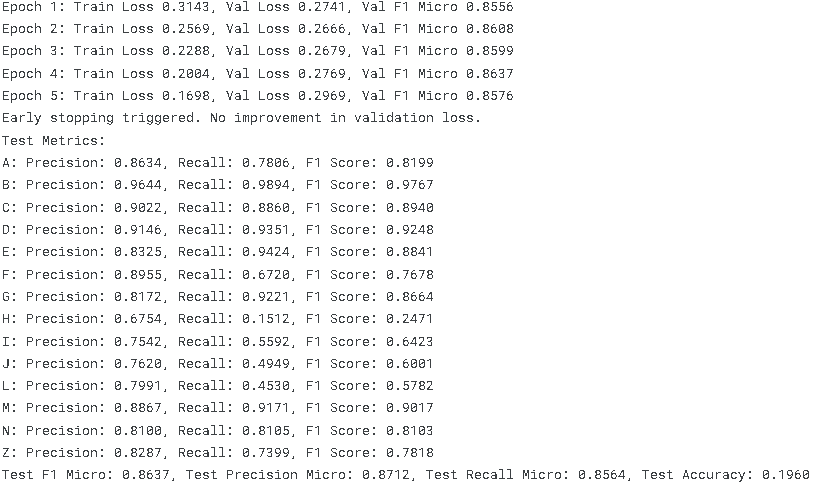